# Bigrams

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

## Count and Probability Based Word Generation

### Loading Data

In [2]:
checkSpecialChar = lambda s: re.match(r"^[A-Za-z]+$", s) is not None
text_file = open('data/first_name.txt').read().splitlines()
text_file = [x.lower() for x in text_file if isinstance(x, str) and checkSpecialChar(x)]
csv_names = [x for x in pd.read_csv('data/Indian_names.csv')['Name'] if isinstance(x, str) and checkSpecialChar(x)]
words = text_file + csv_names
words = list(set(words))

In [3]:
print(len(words))

7904


In [4]:
min(len(word) for word in words)

2

In [5]:
max(len(word) for word in words)

19

### Next word counts

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
N = torch.zeros((len(stoi), len(stoi)), dtype=torch.int32)

In [7]:
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

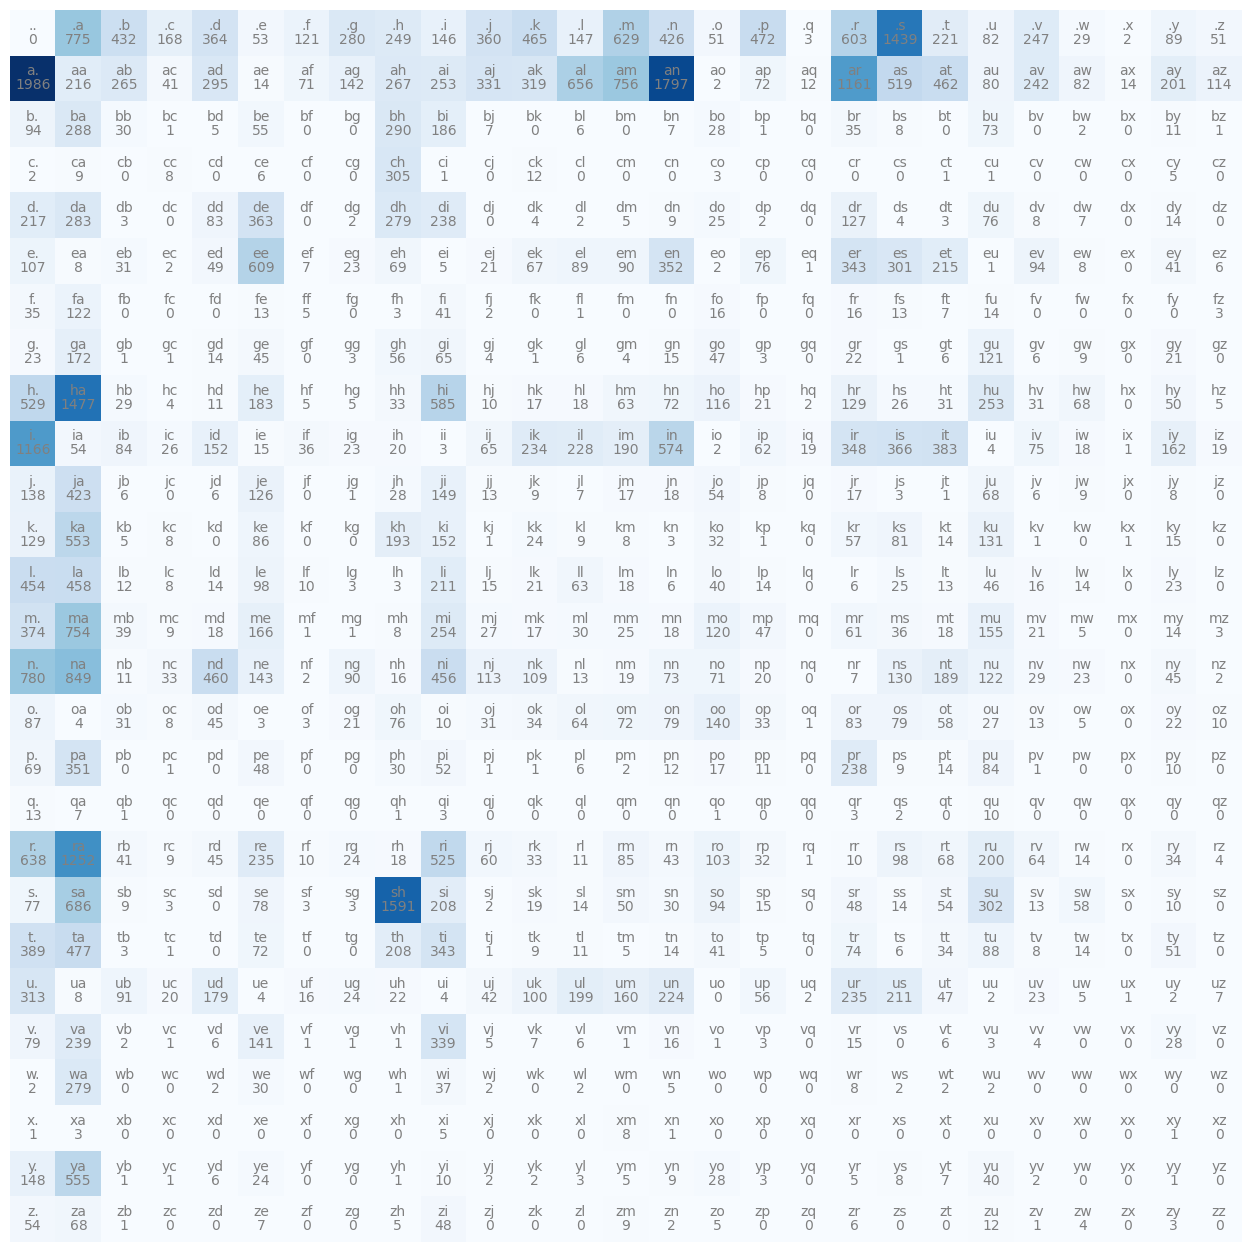

In [8]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')

for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')

### Calculating the probabilities

In [9]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

(-0.5, 26.5, 26.5, -0.5)

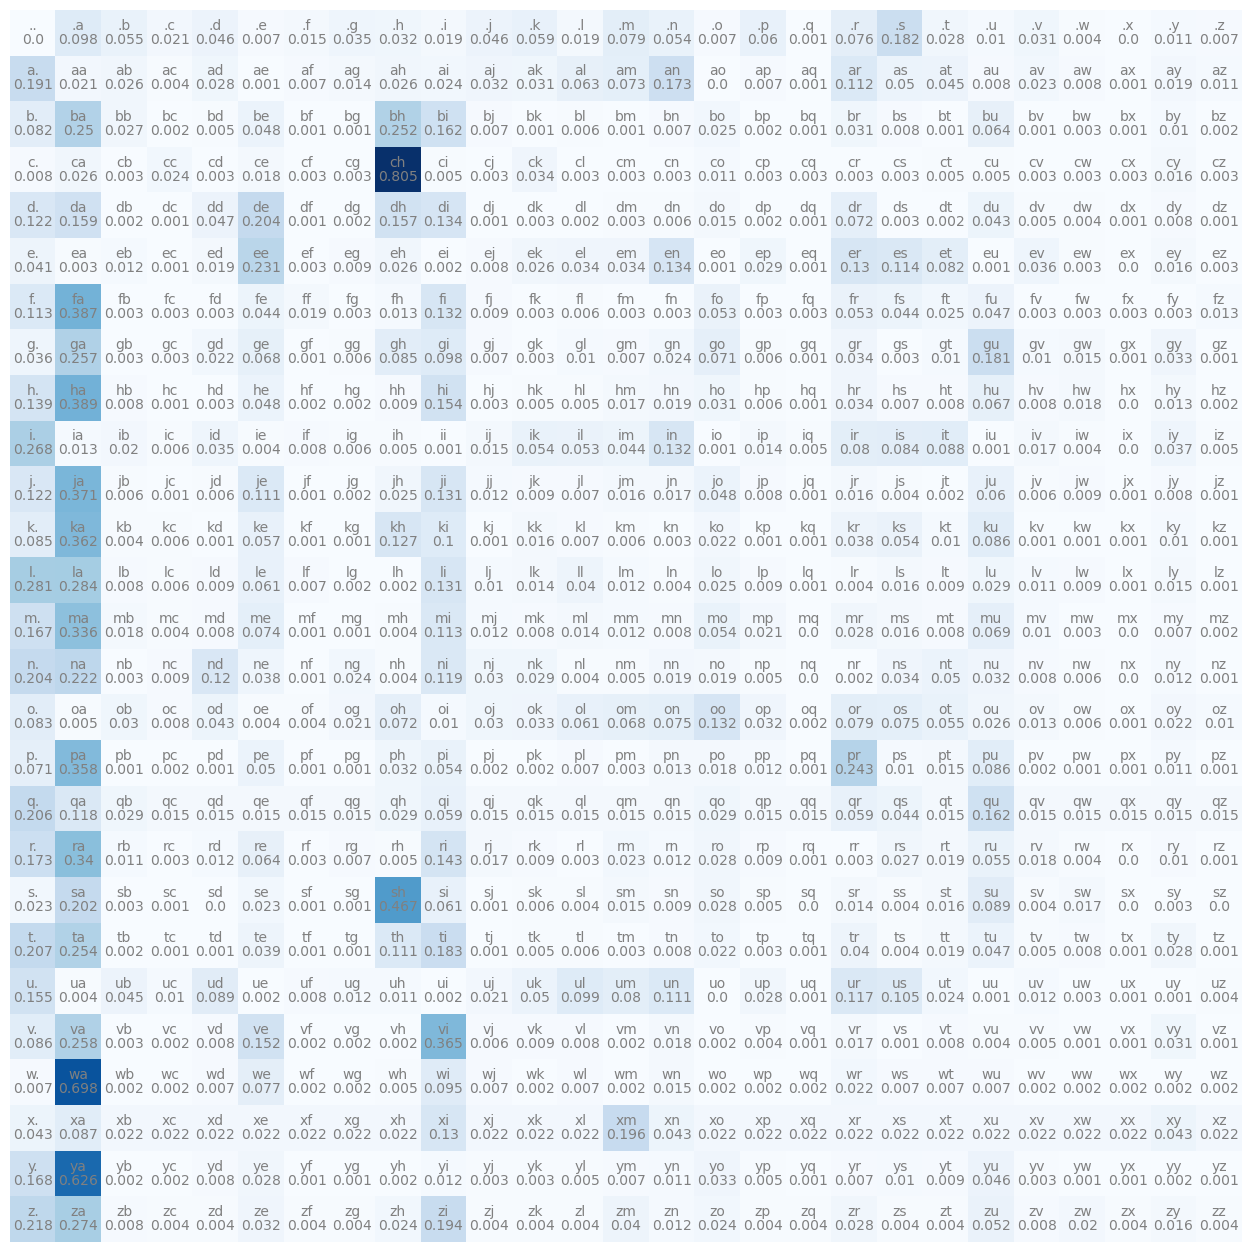

In [10]:
plt.figure(figsize=(16, 16))
plt.imshow(P, cmap='Blues')

for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, round(P[i, j].item(), 3), ha='center', va='top', color='gray')
plt.axis('off')

### Random Word Generation

In [11]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junidedil.
akar.
p.
sfay.
a.
na.
kuhinitohirasatha.
vilanaauranileviaj.
dedainrwi.
sh.
shaninay.
arta.
favaumarafod.
muj.
prinsumahajani.
cora.
yar.
panar.
sabhinerimikim.
ynin.


## Loss Based Optimization

### Single NLL Loss for next word probabilities

In [12]:
nll = 0.0
n = 0
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        nll -= torch.log(P[ix1, ix2])
        n += 1
        
print(nll / n)

tensor(2.3592)


### Training Set generation

In [37]:
# create the training set
xs, ys = [], []
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"Number of elements: {num}")

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((len(stoi), len(stoi)), requires_grad=True)

Number of elements: 58711


### Training and Optimization

In [38]:
for k in range(100):
    xenc = F.one_hot(xs, num_classes=len(stoi)).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)

    loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * W.pow(2).mean()
    print(loss.item())

    W.grad = None
    loss.backward()

    W.data += -50 * W.grad

3.723292350769043
3.268608331680298
3.0356252193450928
2.9009170532226562
2.8102238178253174
2.7446532249450684
2.6943650245666504
2.654517412185669
2.6223256587982178
2.595916748046875
2.5739779472351074
2.5555596351623535
2.539954662322998
2.5266215801239014
2.5151352882385254
2.5051615238189697
2.496432304382324
2.4887356758117676
2.4819021224975586
2.475797176361084
2.4703116416931152
2.4653570652008057
2.460861921310425
2.456766366958618
2.4530203342437744
2.449582576751709
2.4464168548583984
2.4434943199157715
2.4407882690429688
2.438276529312134
2.4359395503997803
2.4337613582611084
2.4317264556884766
2.4298224449157715
2.4280378818511963
2.4263620376586914
2.4247865676879883
2.42330265045166
2.421903133392334
2.420581817626953
2.4193320274353027
2.418148994445801
2.417027711868286
2.415963888168335
2.4149527549743652
2.4139909744262695
2.4130747318267822
2.4122021198272705
2.4113688468933105
2.4105730056762695
2.4098119735717773
2.409083843231201
2.408385992050171
2.40771698951

### Next word generation

In [39]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=len(stoi)).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)


        ix = torch.multinomial(probs, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junidedil.
akar.
p.
sfay.
a.
na.
kurinitohirasatha.
vilanaauranileviaj.
dedainrwam.
r.
shaninay.
arta.
favaumarafod.
muj.
prinshwahajani.
cora.
yar.
panar.
sabhinerimikim.
yain.
